# 1. Deep learning with Python

## 1.1. Fully connected Neural Network  (2-layer network)

##  Function approximation with fully connected NN

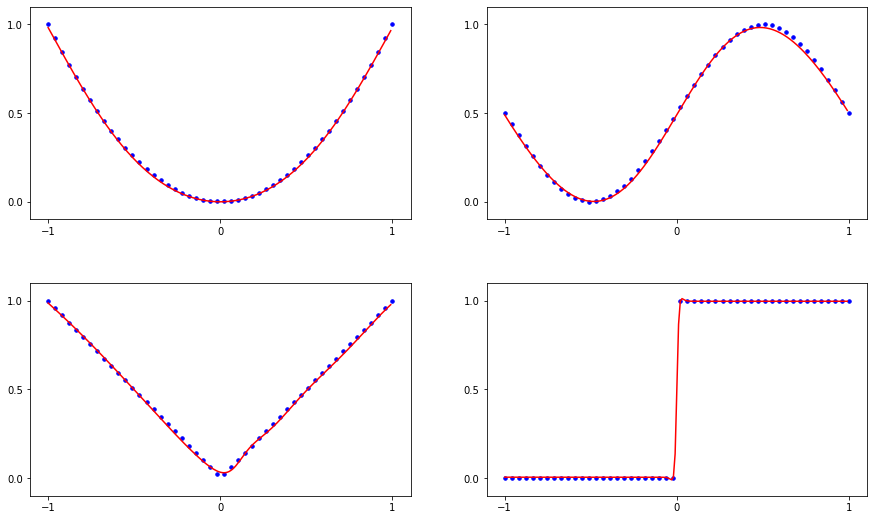

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.nn.two_layer_net import Two_layer_net
from deepL_module.nn.optimizers import *

N = 50 # sample
max_iter = 2000 # iteration num


heaviside = lambda x : 0.5 * (1 + np.sign(x))
sinusoidal = lambda x : 0.5 + 0.5 * np.sin(np.pi * x)


# training data
train_x = np.linspace(-1, 1, N).reshape(N,1)
multi_func = [np.square, sinusoidal, np.abs, heaviside]

# test data
x = np.arange(-1,1,0.01).reshape(-1,1)

fig = plt.figure(figsize=(15, 9))
for n,func in enumerate(multi_func,1):
    
    train_y = func(train_x)
    '''----- plot training data -----'''
    ax = fig.add_subplot(2,2,n)
    ax.scatter(train_x, train_y,s=12,color='blue')
    
    '''----- Constructing NN -----'''
    model = Two_layer_net(1,4,1)
    model.add(['tanh','linear'])
    optimizer = Adam(lr = 0.1, beta_1 = 0.95, beta_2 = 0.95)
    
    '''-----learning------'''
    for _ in range(int(max_iter)):
        grads = model.gradient(train_x,train_y)
        optimizer.update(model.params, grads)

    # prediction data
    y = model.predict(x)
    ax.plot(x, y, 'r-')
    plt.xticks([-1,0,1])
    plt.yticks([0,0.5,1])
    plt.ylim([-0.1, 1.1])
    plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

## Binary class classification using a neural network

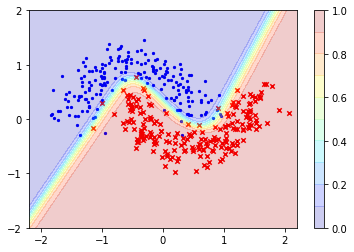

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from deepL_module.nn.two_layer_net import Two_layer_net
from deepL_module.nn.optimizers import *

def create_noise_data(sample:int=400):
    x,labels = make_moons(sample, noise = 0.2)
    x[:,0] -= 0.5
    return x, labels.reshape(-1, 1)


# training dataset
train_x, labels = create_noise_data()

# test dataset
X,Y = np.meshgrid(np.linspace(-3, 3, 100),np.linspace(-3, 3, 100))
test_x = np.array([X.ravel(), Y.ravel()]).reshape(2,-1).T


'''---Constructing the NN---'''
model = Two_layer_net(2,3,1)
model.add(['tanh','sigmoid'])
optimizer = Adam(lr = 0.1)


'''---Learning the training data---'''
for _ in range(int(250)):
    grads = model.gradient(train_x,labels)
    optimizer.update(model.params, grads)



# plot the training data
plt.scatter(train_x[labels.ravel() == 0,0],
            train_x[labels.ravel() == 0,1],
            marker = ".", s = 20, color = 'b')

plt.scatter(train_x[labels.ravel() == 1,0],
            train_x[labels.ravel() == 1,1],
            marker = "x", s = 20, color = 'r')


# plot the test data
Z = model.predict(test_x)
plt.contourf(X, Y, Z.reshape(X.shape), levels=np.linspace(0, 1, 11), alpha=0.2,cmap='jet')
plt.colorbar()

# axis setting
plt.xlim(-2.2,2.2)
plt.ylim(-2.,2.)
plt.xticks(np.arange(-2,3,1))
plt.yticks(np.arange(-2,3,1))
plt.show()


## 1.2 Comparison of other optimizer

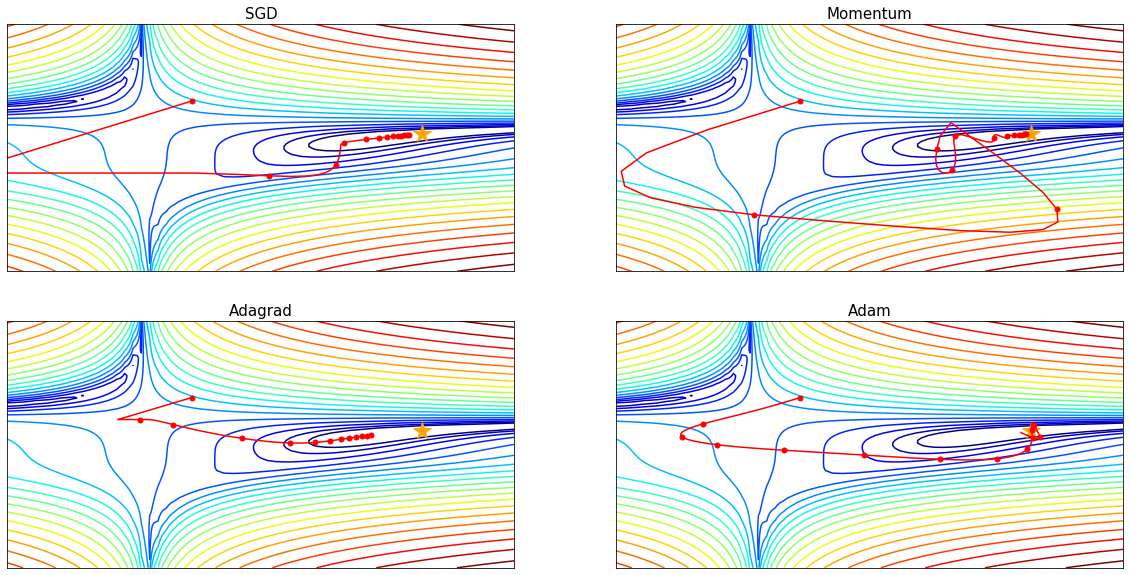

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from deepL_module.base.functions import *
from deepL_module.nn.optimizers import *
from collections import OrderedDict


init_pos = [0.5,1.7]

init_pos = np.array(init_pos).astype(float)

params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.05)
optimizers["Momentum"] = Momentum(lr=0.02,momentum=0.8)
optimizers["Adagrad"] = Adagrad(lr=0.8)
optimizers["Adam"] = Adam(lr=0.2,beta_1=0.95,beta_2=0.999)

idx = 1
fig = plt.figure(figsize=(20,10))
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    ax = fig.add_subplot(2, 2, idx)
    train_x, train_y = np.linspace(-4.5,4.5,100), np.linspace(-4.5,4.5,100)
    X, Y = np.meshgrid(train_x,train_y)
    Z = beal_function(X, Y)
    ax.contour(X, Y, Z, levels=np.logspace(0,5,20), norm=LogNorm(), cmap='jet')
    ax.plot(*np.array([3,0.5]),'r*',markersize=18,color='orange')

    for i in range(90):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = grad_beal(params['x'], params['y'])
        optimizer.update(params, grads)

    idx += 1
    ax.plot(x_history, y_history, 'o-', color="r",markersize=5,markevery=7)
    plt.ylim(-4.5, 4.5)
    plt.xlim(-1.5, 4.)
    plt.title(key,fontsize=15)
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

plt.show()